## Dependencies

In [1]:
import os
import sys
import cv2
import shutil
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow import set_random_seed
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score, classification_report
from keras import backend as K
from keras.models import Model
from keras.utils import to_categorical
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, Callback, LearningRateScheduler

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(0)

seed = 0
seed_everything(seed)
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")
sys.path.append(os.path.abspath('../input/efficientnet/efficientnet-master/efficientnet-master/'))
from efficientnet import *

Using TensorFlow backend.


## Load data

In [2]:
hold_out_set = pd.read_csv('../input/aptos-data-split/hold-out.csv')
X_train = hold_out_set[hold_out_set['set'] == 'train']
X_val = hold_out_set[hold_out_set['set'] == 'validation']
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', X_train.shape[0])
print('Number of validation samples: ', X_val.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
X_train["id_code"] = X_train["id_code"].apply(lambda x: x + ".png")
X_val["id_code"] = X_val["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
display(X_train.head())

Number of train samples:  2929
Number of validation samples:  733
Number of test samples:  1928


,id_code,diagnosis,height,width,set
0,55eac26bd383.png,1,1736,2416,train
1,44e0d56e9d42.png,2,2136,3216,train
2,aa4407aab872.png,0,1050,1050,train
3,cffc50047828.png,0,614,819,train
4,b0f0fa677d5f.png,0,1050,1050,train


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 30
WARMUP_EPOCHS = 5
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 456
WIDTH = 456
CHANNELS = 3
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5
LR_WARMUP_EPOCHS_1st = 2
LR_WARMUP_EPOCHS_2nd = 5
STEP_SIZE = (5 * (len(X_train) // BATCH_SIZE)) / 2

# Pre-procecess images

In [4]:
train_base_path = '../input/aptos2019-blindness-detection/train_images/'
test_base_path = '../input/aptos2019-blindness-detection/test_images/'
train_dest_path = 'base_dir/train_images/'
validation_dest_path = 'base_dir/validation_images/'
test_dest_path =  'base_dir/test_images/'

# Making sure directories don't exist
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)
    
# Creating train, validation and test directories
os.makedirs(train_dest_path)
os.makedirs(validation_dest_path)
os.makedirs(test_dest_path)

def crop_image(img, tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
            
        return img

def circle_crop(img):
    img = crop_image(img)

    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))

    height, width, depth = img.shape

    x = width//2
    y = height//2
    r = np.amin((x, y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image(img)

    return img
    
def preprocess_image(base_path, save_path, image_id, HEIGHT, WIDTH, sigmaX=10):
    image = cv2.imread(base_path + image_id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = circle_crop(image)
    image = cv2.resize(image, (HEIGHT, WIDTH))
    image = cv2.addWeighted(image, 4, cv2.GaussianBlur(image, (0,0), sigmaX), -4 , 128)
    cv2.imwrite(save_path + image_id, image)
    
# Pre-procecss train set
for i, image_id in enumerate(X_train['id_code']):
    preprocess_image(train_base_path, train_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss validation set
for i, image_id in enumerate(X_val['id_code']):
    preprocess_image(train_base_path, validation_dest_path, image_id, HEIGHT, WIDTH)
    
# Pre-procecss test set
for i, image_id in enumerate(test['id_code']):
    preprocess_image(test_base_path, test_dest_path, image_id, HEIGHT, WIDTH)

# Data generator

In [5]:
datagen=ImageDataGenerator(rescale=1./255, 
                           rotation_range=360,
                           horizontal_flip=True,
                           vertical_flip=True)

train_generator=datagen.flow_from_dataframe(
                          dataframe=X_train,
                          directory=train_dest_path,
                          x_col="id_code",
                          y_col="diagnosis",
                          class_mode="raw",
                          batch_size=BATCH_SIZE,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

valid_generator=datagen.flow_from_dataframe(
                        dataframe=X_val,
                        directory=validation_dest_path,
                        x_col="id_code",
                        y_col="diagnosis",
                        class_mode="raw",
                        batch_size=BATCH_SIZE,
                        target_size=(HEIGHT, WIDTH),
                        seed=seed)

test_generator=datagen.flow_from_dataframe(  
                          dataframe=test,
                          directory=test_dest_path,
                          x_col="id_code",
                          batch_size=1,
                          class_mode=None,
                          shuffle=False,
                          target_size=(HEIGHT, WIDTH),
                          seed=seed)

Found 2929 validated image filenames.
Found 733 validated image filenames.
Found 1928 validated image filenames.


In [6]:
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency.
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.
    # Example for CIFAR-10 w/ batch size 100:
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # References
      - [Cyclical Learning Rates for Training Neural Networks](
      https://arxiv.org/abs/1506.01186)
    """

    def __init__(self,
                base_lr=0.001,
                max_lr=0.006,
                step_size=2000.,
                mode='triangular',
                gamma=1.,
                scale_fn=None,
                scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        if mode not in ['triangular', 'triangular2', 'exp_range']:
            raise KeyError("mode must be one of 'triangular', ""'triangular2', or 'exp_range'")
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn is None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1 / (2.**(x - 1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma ** x
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        if new_base_lr is not None:
            self.base_lr = new_base_lr
        if new_max_lr is not None:
            self.max_lr = new_max_lr
        if new_step_size is not None:
            self.step_size = new_step_size
        self.clr_iterations = 0.

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * \
                np.maximum(0, (1 - x)) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):

        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())

        self.history.setdefault(
            'lr', []).append(
            K.get_value(
                self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

# Model

In [7]:
def create_model(input_shape):
    input_tensor = Input(shape=input_shape)
    base_model = EfficientNetB5(weights=None, 
                                include_top=False,
                                input_tensor=input_tensor)
    base_model.load_weights('../input/efficientnet-keras-weights-b0b5/efficientnet-b5_imagenet_1000_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(1, activation='linear', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [8]:
model = create_model(input_shape=(HEIGHT, WIDTH, CHANNELS))

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True

cyclic_lr_1st = CyclicLR(base_lr=(WARMUP_LEARNING_RATE / 10),
                         max_lr=(WARMUP_LEARNING_RATE * 2),
                         step_size=STEP_SIZE,
                         mode='triangular')

metric_list = ["accuracy"]
callback_list = [cyclic_lr_1st]
optimizer = optimizers.RMSprop(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [9]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     callbacks=callback_list,
                                     verbose=2).history

Epoch 1/5
 - 187s - loss: 1.1798 - acc: 0.4187 - val_loss: 1.3690 - val_acc: 0.2637
Epoch 2/5
 - 176s - loss: 1.1530 - acc: 0.4293 - val_loss: 1.9793 - val_acc: 0.3614
Epoch 3/5
 - 176s - loss: 1.1305 - acc: 0.4426 - val_loss: 1.8631 - val_acc: 0.2800
Epoch 4/5
 - 177s - loss: 1.0535 - acc: 0.4477 - val_loss: 1.4830 - val_acc: 0.2193
Epoch 5/5
 - 176s - loss: 0.9067 - acc: 0.5137 - val_loss: 1.6835 - val_acc: 0.2372


# Fine-tune the complete model

In [10]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
cyclic_lr_2nd = CyclicLR(base_lr=(LEARNING_RATE / 10),
                         max_lr=(LEARNING_RATE * 2),
                         step_size=STEP_SIZE,
                         mode='triangular')

callback_list = [es, cyclic_lr_2nd]
optimizer = optimizers.RMSprop(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 456, 456, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 228, 228, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 228, 228, 48) 192         conv2d_1[0][0]                   
__________________________________________________________________________________________________
swish_1 (Swish)                 (None, 228, 228, 48) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
depthwise_

In [11]:
history = model.fit_generator(generator=train_generator,
                              steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator,
                              validation_steps=STEP_SIZE_VALID,
                              epochs=EPOCHS,
                              callbacks=callback_list,
                              verbose=2).history

Epoch 1/30
 - 395s - loss: 0.7728 - acc: 0.5451 - val_loss: 0.7642 - val_acc: 0.5021
Epoch 2/30
 - 368s - loss: 0.6192 - acc: 0.5970 - val_loss: 0.5013 - val_acc: 0.7117
Epoch 3/30
 - 367s - loss: 0.5623 - acc: 0.6516 - val_loss: 0.4125 - val_acc: 0.7269
Epoch 4/30
 - 368s - loss: 0.4561 - acc: 0.7070 - val_loss: 0.3246 - val_acc: 0.7683
Epoch 5/30
 - 368s - loss: 0.3641 - acc: 0.7295 - val_loss: 0.2801 - val_acc: 0.7848
Epoch 6/30
 - 369s - loss: 0.3386 - acc: 0.7445 - val_loss: 0.3326 - val_acc: 0.7724
Epoch 7/30
 - 368s - loss: 0.3570 - acc: 0.7394 - val_loss: 0.3526 - val_acc: 0.7628
Epoch 8/30
 - 368s - loss: 0.3995 - acc: 0.7172 - val_loss: 0.2977 - val_acc: 0.7890
Epoch 9/30
 - 368s - loss: 0.3386 - acc: 0.7432 - val_loss: 0.2757 - val_acc: 0.8041
Epoch 10/30
 - 367s - loss: 0.2909 - acc: 0.7695 - val_loss: 0.2661 - val_acc: 0.8083
Epoch 11/30
 - 368s - loss: 0.2692 - acc: 0.7729 - val_loss: 0.2516 - val_acc: 0.8138
Epoch 12/30
 - 369s - loss: 0.2703 - acc: 0.7825 - val_loss: 0.

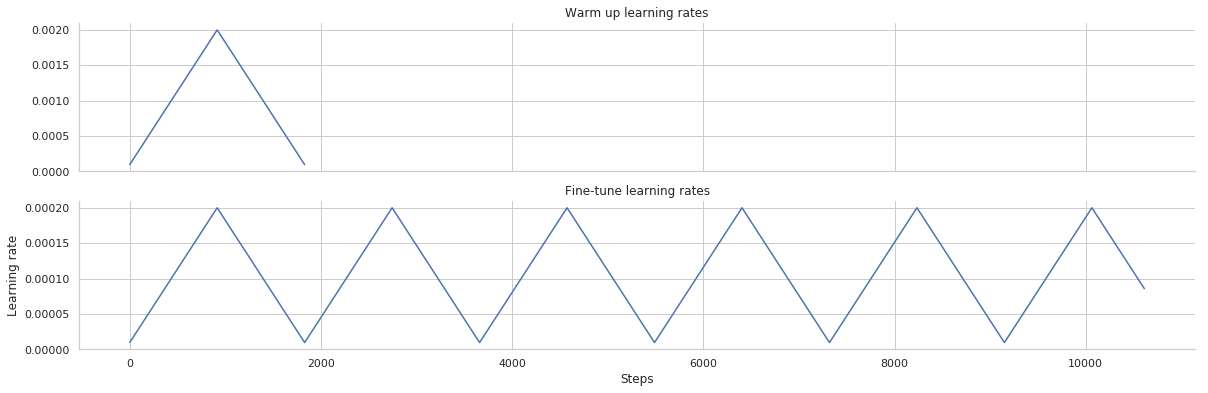

In [12]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 6))

ax1.plot(cyclic_lr_1st.history['lr'])
ax1.set_title('Warm up learning rates')

ax2.plot(cyclic_lr_2nd.history['lr'])
ax2.set_title('Fine-tune learning rates')

plt.xlabel('Steps')
plt.ylabel('Learning rate')
sns.despine()
plt.show()

# Model loss graph 

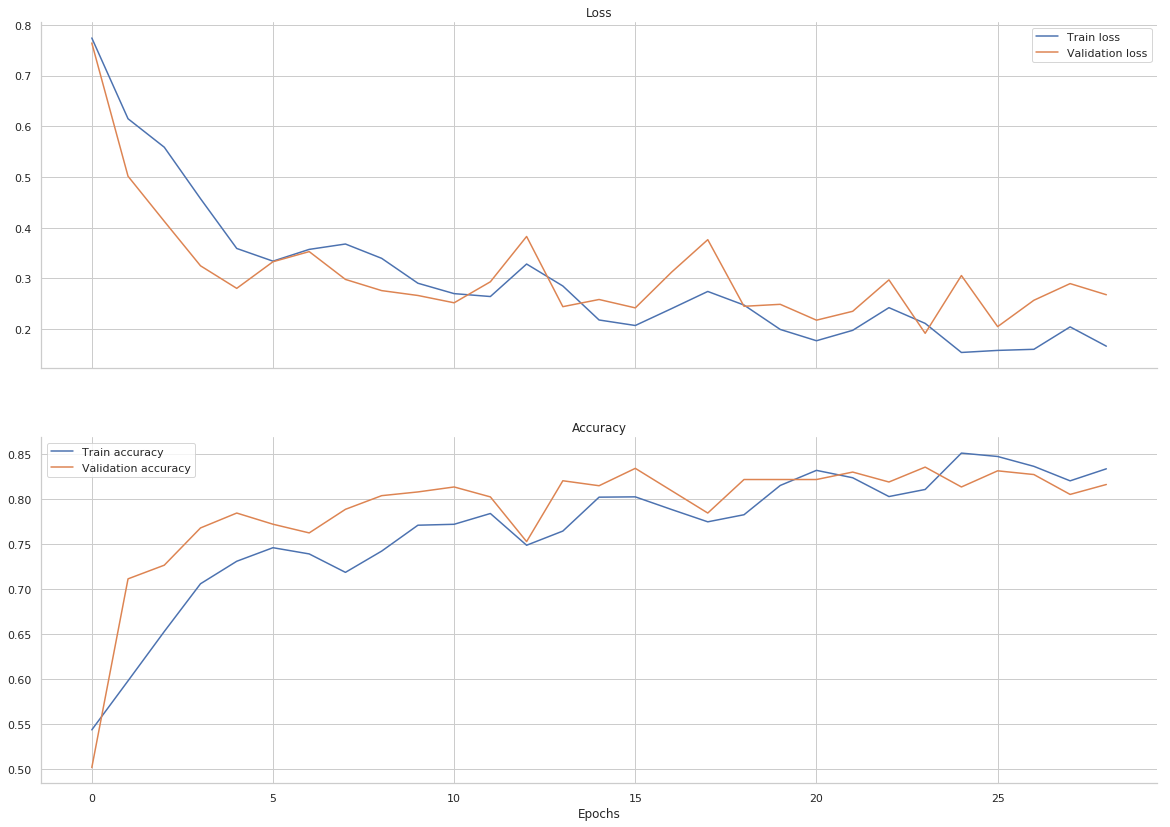

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

In [14]:
# Create empty arays to keep the predictions and labels
df_preds = pd.DataFrame(columns=['label', 'pred', 'set'])
train_generator.reset()
valid_generator.reset()

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN + 1):
    im, lbl = next(train_generator)
    preds = model.predict(im, batch_size=train_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'train']

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID + 1):
    im, lbl = next(valid_generator)
    preds = model.predict(im, batch_size=valid_generator.batch_size)
    for index in range(len(preds)):
        df_preds.loc[len(df_preds)] = [lbl[index], preds[index][0], 'validation']

df_preds['label'] = df_preds['label'].astype('int')

In [15]:
def classify(x):
    if x < 0.5:
        return 0
    elif x < 1.5:
        return 1
    elif x < 2.5:
        return 2
    elif x < 3.5:
        return 3
    return 4

# Classify predictions
df_preds['predictions'] = df_preds['pred'].apply(lambda x: classify(x))

train_preds = df_preds[df_preds['set'] == 'train']
validation_preds = df_preds[df_preds['set'] == 'validation']

# Model Evaluation

In [16]:
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
def evaluate_model(train, validation):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    print("Train        Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds, train_labels, weights='quadratic'))
    print("Validation   Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
    print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(np.append(train_preds, validation_preds), np.append(train_labels, validation_labels), weights='quadratic'))
    print(' \t\t\t\t   TRAIN')
    print(classification_report(train_labels, train_preds, target_names=labels))
    print(' \t\t\t\t VALIDATION')
    print(classification_report(validation_labels, validation_preds, target_names=labels))
    
evaluate_model((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

Train        Cohen Kappa score: 0.966
Validation   Cohen Kappa score: 0.921
Complete set Cohen Kappa score: 0.957
 				   TRAIN
                      precision    recall  f1-score   support

           0 - No DR       1.00      1.00      1.00      1452
            1 - Mild       0.92      0.69      0.79       299
        2 - Moderate       0.87      0.86      0.86       791
          3 - Severe       0.45      0.63      0.53       162
4 - Proliferative DR       0.80      0.86      0.83       225

            accuracy                           0.90      2929
           macro avg       0.81      0.81      0.80      2929
        weighted avg       0.91      0.90      0.90      2929

 				 VALIDATION
                      precision    recall  f1-score   support

           0 - No DR       0.99      0.98      0.98       353
            1 - Mild       0.69      0.59      0.64        71
        2 - Moderate       0.75      0.73      0.74       208
          3 - Severe       0.16      0.35    

## Confusion Matrix

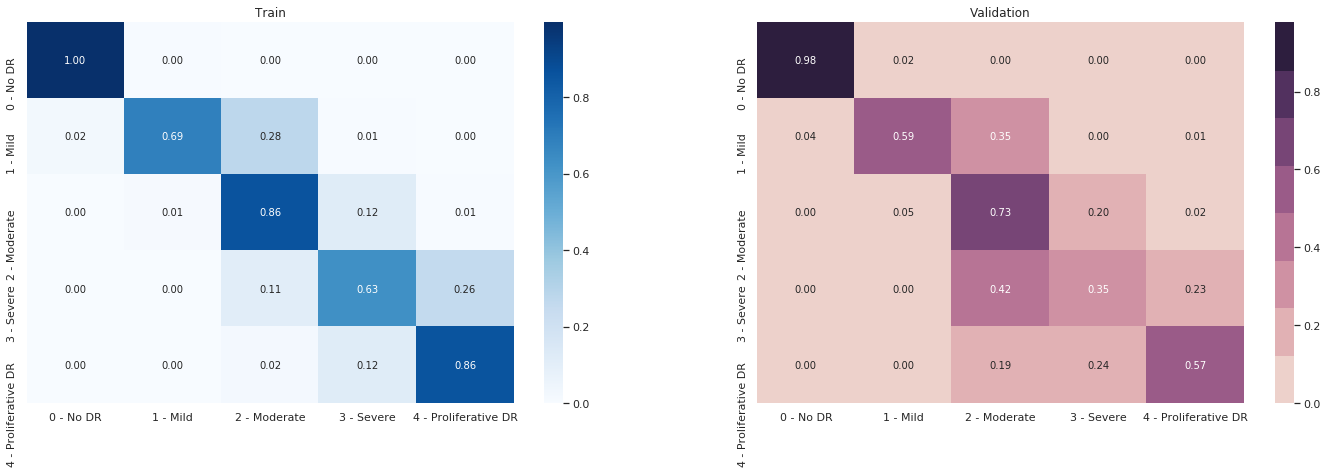

In [17]:
def plot_confusion_matrix(train, validation, labels=labels):
    train_labels, train_preds = train
    validation_labels, validation_preds = validation
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
    train_cnf_matrix = confusion_matrix(train_labels, train_preds)
    validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

    train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
    validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

    train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
    validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

    sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues",ax=ax1).set_title('Train')
    sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8),ax=ax2).set_title('Validation')
    plt.show()

plot_confusion_matrix((train_preds['label'], train_preds['predictions']), (validation_preds['label'], validation_preds['predictions']))

## Apply model to test set and output predictions

In [18]:
def apply_tta(model, generator, steps=10):
    step_size = generator.n//generator.batch_size
    preds_tta = []
    for i in range(steps):
        generator.reset()
        preds = model.predict_generator(generator, steps=step_size)
        preds_tta.append(preds)

    return np.mean(preds_tta, axis=0)

preds = apply_tta(model, test_generator)
predictions = [classify(x) for x in preds]

results = pd.DataFrame({'id_code':test['id_code'], 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

In [19]:
# Cleaning created directories
if os.path.exists(train_dest_path):
    shutil.rmtree(train_dest_path)
if os.path.exists(validation_dest_path):
    shutil.rmtree(validation_dest_path)
if os.path.exists(test_dest_path):
    shutil.rmtree(test_dest_path)

# Predictions class distribution

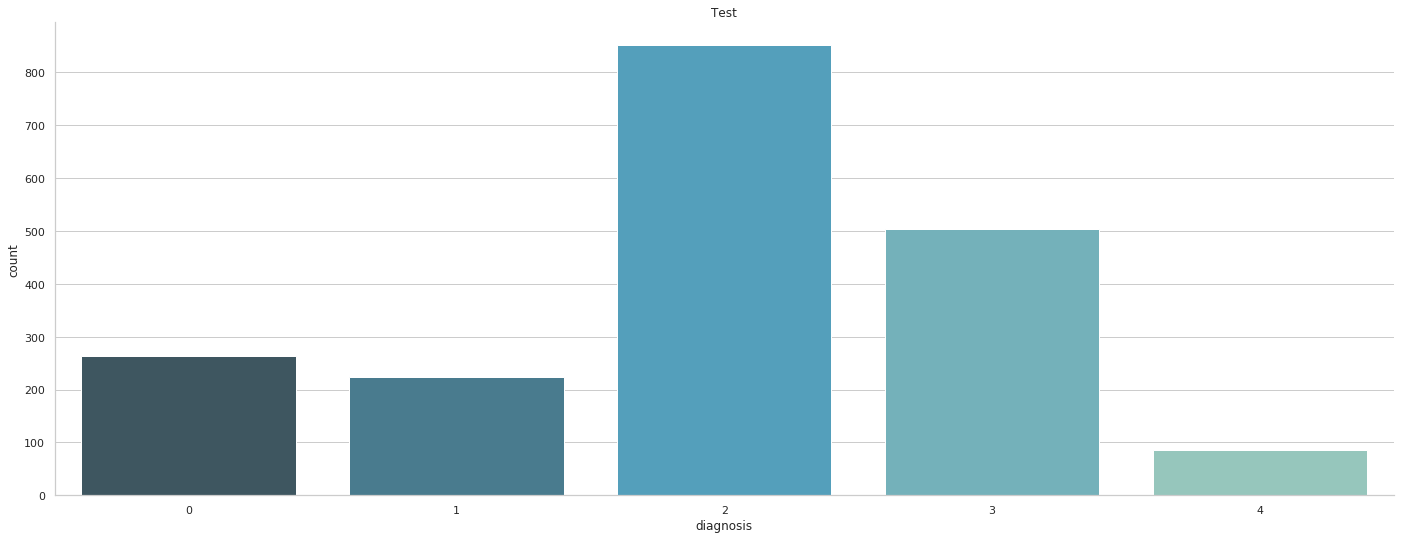

In [20]:
fig = plt.subplots(sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d").set_title('Test')
sns.despine()
plt.show()

In [21]:
results.to_csv('submission.csv', index=False)
display(results.head())

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,3
4,009245722fa4,3
